## Objective
Run algorithm on spikeinterface recording

si_rec4.ipynb -> si_rec5.ipynb: Better coding

## General setup

In [1]:
%load_ext autoreload

In [2]:
from importlib import reload
from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
from math import ceil

from multiprocessing import Pool
from pandas import DataFrame

from tqdm import tqdm

%autoreload 2
from src.run_alg import si_rec5 as F
from src.sorters.prop_signal import PropSignal, PropUnit
from src.sorters.kilosort import get_experts_kilosort
from src.sorters.base import SpikeSorter, Unit
from src.comparison import Comparison, DummySorter
from src import utils, plot
from src.sorters.kilosort import get_experts_kilosort

In [3]:
import pickle
from joblib import Parallel, delayed
from copy import deepcopy
from pathlib import Path

# Test parallel processing with joblib
# from joblib import Parallel, delayed
# def test(_):
#     data = np.random.random(1000).reshape((-1, 2))
#     gmm = GaussianMixture(n_components=6, init_params="kmeans", covariance_type="diag")
#     gmm.fit(data)
#     return None
    
# # Full run 
# # all_props = []
# Parallel(n_jobs=20)(delayed(test)(x) for x in tqdm(range(300)))

In [4]:
recording = RECORDING = utils.rec_si()  # lowercase for easier implementation in .py functions. uppercase for jupyter notebook
samp_freq = RECORDING.get_sampling_frequency()
chans_rms = CHANS_RMS = utils.chans_rms_si()
num_elecs = RECORDING.get_num_channels()

COC_DICT_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/coc_dicts")  # /{elec}.pickle

# cross_times = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/spike_times.npy", allow_pickle=True)
# cross_amps = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/spike_amps.npy", allow_pickle=True)
# NOTE: For DL, cross_amps retain sign of original data (i.e. positive or negative)

# Need to eliminate some crosses with 0 amplitude (bug in raw_recording.ipynb in DL project, not sure why/where) --> handle this when forming coc_dicts
# cross_times = []
# cross_amps = []
# for times, amps in tqdm(zip(cross_times_og, cross_amps_og), total=len(cross_times_og)):
#     ind = ~np.isclose(amps, 0)
#     cross_times.append(np.array(times)[ind])
#     cross_amps.append(np.array(amps)[ind])

# TODO: How DL detects cross_amps needs to be fixed
# total = 0
# for amps in tqdm(cross_amps):
#     amps = np.array(amps)
#     ind = amps < 0
#     total += sum(ind)

# print(total)

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])


Recording does not have scaled traces. Setting gain to 0.195


In [5]:
# TRAINING_FRAMES for forming sequences while TESTING_FRAMES if for comparing with kilosort
TRAINING_FRAMES = (0, 5*60*1000)  # 0 min to 5 min in recording (in ms)
TESTING_FRAMES = (5*60*1000, 10*60*1000)  # 5 min to 10 min in recording (in ms)

In [6]:
"""  closest_elecs
Index in closest_elecs is electrode index.
Each element is list containing electrode indices sorted by
ascending distance from index electrode (excluding index electrode itself)
"""
all_closest_elecs = []

elec_locs = RECORDING.get_channel_locations()
for elec in range(num_elecs):
    elec_ind = []
    dists = []
    x1, y1 = elec_locs[elec]
    for elec2 in range(RECORDING.get_num_channels()):
        if elec == elec2:
            continue
        x2, y2 = elec_locs[elec2]
        dists.append(np.sqrt((x2 - x1)**2 + (y2 - y1)**2))
        elec_ind.append(elec2)
    order = np.argsort(dists)
    all_closest_elecs.append(np.array(elec_ind)[order])   
    

def calc_elec_dist(elec1, elec2):
    # Calculate the spatial distance between two electrodes
    x1, y1 = elec_locs[elec1]
    x2, y2 = elec_locs[elec2]
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def get_nearby_elecs(ref_elec, max_dist=100):
    nearby_elecs = []
    for elec in all_closest_elecs[ref_elec]:
        if calc_elec_dist(ref_elec, elec) <= max_dist:
            nearby_elecs.append(elec)
    return nearby_elecs

def get_merge_elecs(ref_elec, max_dist=100):
    # [ref_elec] + get_nearby_elecs
    return [ref_elec] + get_nearby_elecs(ref_elec, max_dist)

mean amp: -52.3660774230957


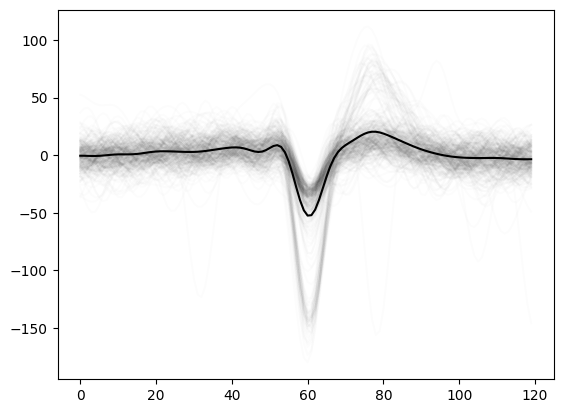

In [ ]:
# Plot cross times on one channel
CHAN = 0
N = 300

N_BEFORE = 60
N_AFTER = 60

np.random.seed(231)
##
traces = [] 
for _ in range(N):
    time_ms = np.random.choice(cross_times[CHAN])
    time = int(time_ms * RECORDING.get_sampling_frequency())
    trace = RECORDING.get_traces_filt(time-N_BEFORE, time+N_AFTER, CHAN).flatten()
    
    plt.plot(trace, color="black", alpha=0.01)
    
    traces.append(trace)
traces = np.stack(traces)
trace_mean = np.mean(traces, axis=0)
print(f"mean amp: {np.min(trace_mean)}")

plt.plot(trace_mean, color="black")

plt.show()

## Form propagations
Form sequence backbones on root electrode  
Merge sequence backbones with the same root electrode  
Assign spikes to sequences  
Merge sequences with the same root electrode (intraelectrode merging)  
Merge sequences with different root electrodes (interelectrode merging)  

### Run once for recording

In [ ]:
# Reformat cross_times into one long array
all_crossings = []  # [(elec_idx, time, amp)]
elec_crossings_ind = [[] for _ in range(len(cross_times))]  # ith element for elec idx i. Contains ind in all_crossings for elec idx i's crossings

pointers = [0] * len(cross_times)  # Where to index next time in each electrode's crossings (So all_crossings is sorted in time)
for t in tqdm(range(sum((len(t) for t in cross_times)))):
    next_time = np.inf
    next_amp = None
    next_elec = None
    for elec, idx in enumerate(pointers):
        if idx == len(cross_times[elec]):
            continue
        
        time = cross_times[elec][idx]
        if time < next_time:
            next_time = time
            next_amp = cross_amps[elec][idx]
            next_elec = elec
    
    all_crossings.append((next_elec, next_time, next_amp))
    elec_crossings_ind[next_elec].append(t)
    pointers[next_elec] += 1

100%|██████████| 7034141/7034141 [08:49<00:00, 13296.60it/s]


In [7]:
# np.save("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/all_crossings.npy", np.array(all_crossings, dtype=object))
# np.save("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/elec_crossings_ind.npy", np.array(elec_crossings_ind, dtype=object))

all_crossings = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/all_crossings.npy", allow_pickle=True)
elec_crossings_ind = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/elec_crossings_ind.npy", allow_pickle=True)
# Reformat for faster retrieval
all_crossings = [tuple(cross) for cross in all_crossings]
elec_crossings_ind = [tuple(ind) for ind in elec_crossings_ind]  # [(elec's cross times ind in all_crossings)]

In [85]:
def find_elec_cocs(elec_idx,
                   min_amp_ratio=0.9, coactivation_window=0.5,
                   max_elec_dist=200):
    """
    For electrode, return dictionary of
    {
        (elec cross time, elec cross amp): [(other elec idx, other elec cross time, other elec amp)]
    }
    
    If (elec cross time, elec cross amp) not in dictionary, then there was no cooccurrence with another electrode
    
    min_amp_ratio: For all tar_amps for ref_amp, ref_amp / tar_amp has to be at least min_amp_ratio for coocurrence to count as one
        AKA: max_v
    """
    
    coc_dict = {}
    for ref_idx in elec_crossings_ind[elec_idx]:
        _, ref_time, ref_amp = all_crossings[ref_idx]       
        cocs = []
        
        # while idx-1 >= 0 and ref_time - all_crossings[idx-1][1] <= coactivation_window:
        #     idx -= 1
        #     cocs.append(all_crossings[idx])
                   
        # while idx+1 < len(all_crossings) and all_crossings[idx+1][1] - ref_time <= coactivation_window:
        #     idx += 1
        #     cocs.append(all_crossings[idx])
        
        for inc in (-1, 1):  # to handle cocs occurring before and after ref_time, respectively
            idx = ref_idx
            while (0 <= idx+inc < len(all_crossings)) and np.abs(ref_time - all_crossings[idx + inc][1]) <= coactivation_window:
                idx += inc
                tar_crossing = all_crossings[idx]
                
                # TODO: Implement a better solution? (check 231012_prop_notes, around slide 6)                
                if ref_amp / tar_crossing[2] < min_amp_ratio and calc_elec_dist(elec_idx, tar_crossing[0]) <= max_elec_dist:
                    break
                cocs.append(tar_crossing)
            else:
                continue  # Check next inc for cocs
            break  # If while loop was broken, then stop looking for cocs
        else:  # If for loop was not broken, then add cocs
            if len(cocs) > 0:                
                coc_dict[(ref_time, ref_amp)] = cocs
        
        # Not using for loop (instead, this needs copy and pasting)
        # idx = ref_idx
        # while idx-1 >= 0 and ref_time - all_crossings[idx-1][1] <= coactivation_window:  # Add cocs occurring before ref_time
        #     idx -= 1
        #     tar_crossing = all_crossings[idx]
        #     if np.abs(ref_amp / tar_crossing[2]) < min_amp_ratio:
        #         break
        #     cocs.append(tar_crossing)
        # else:           
        #     idx = ref_idx
        #     while idx+1 < len(all_crossings) and all_crossings[idx+1][1] - ref_time <= coactivation_window:  # Add cocs occurring after ref_time
        #         idx += 1
        #         tar_crossing = all_crossings[idx]           
        #         if np.abs(ref_amp / tar_crossing[2]) < min_amp_ratio:
        #             break
        #         cocs.append(tar_crossing)
        #     else:
        #         if len(cocs) > 0:
        #             coc_dict[(ref_time, ref_amp)] = cocs
                    
    return coc_dict

MIN_AMP_RATIO = 0
def save_coc_dict(elec):
    coc_dict = find_elec_cocs(elec, min_amp_ratio=MIN_AMP_RATIO)
    with open(COC_DICT_ROOT / f"max{MIN_AMP_RATIO}/{elec}.pickle", "wb") as f:
        pickle.dump(coc_dict, f, pickle.HIGHEST_PROTOCOL)

with Pool(processes=20) as pool:
    tasks = range(num_elecs)
    for _ in tqdm(pool.imap_unordered(save_coc_dict, tasks), total=len(tasks)):
        pass

100%|██████████| 248/248 [01:04<00:00,  3.86it/s]


### Now form propagations

In [8]:
# Load cross times quickly
def load_coc_dict(elec, max_v=0.9, time_frame=None):
    with open(COC_DICT_ROOT / f"max{max_v}/{elec}.pickle", "rb") as f:
        coc_dict = pickle.load(f)
    if time_frame is not None:
        start_ms, end_ms = time_frame
        new_coc_dict = {}
        for (root_time, root_amp), cocs in coc_dict.items():
            if start_ms <= root_time <= end_ms:
                new_cocs = []
                for elec, time, amp in cocs:
                    if start_ms <= time <= end_ms:
                        new_cocs.append((elec, time, amp))
                if len(new_cocs) > 0:
                    new_coc_dict[(root_time, root_amp)] = new_cocs
        coc_dict = new_coc_dict
    return coc_dict


# # Testing find_elec_cocs   
# # coc_dict = find_elec_cocs(0, min_amp_ratio=0.9, max_elec_dist=200)
# ref_elec = 100
# ##
# coc_dict = load_coc_dict(ref_elec)
# print(len(coc_dict))
    
# times = []
# for (ref_time, ref_amp), cocs in coc_dict.items():
#     for elec, time, amp in cocs:
#         if elec == 97:
#             times.append(ref_time)
# print(len(times))

# unit = Unit(0, times, ref_elec, RECORDING)
# unit.plot(chans_rms=CHANS_RMS)
# plt.show()

In [405]:
class CocCluster:
    def __init__(self, root_elec, time, latency, rel_amp) -> None:
        self.root_elecs = [root_elec]
        self._spike_train = [time]  # Unordered spike train
        self.mean_latency = latency
        self.mean_rel_amp = rel_amp
        
    def add_coc(self, time, latency, rel_amp):        
        mean_latency = len(self._spike_train) * self.mean_latency + latency
        mean_rel_amp = len(self._spike_train) * self.mean_rel_amp + rel_amp
        
        self._spike_train.append(time)
        self.mean_latency = mean_latency / len(self._spike_train)
        self.mean_rel_amp = mean_rel_amp / len(self._spike_train)
        
    def calc_latency_diff(self, other):
        try:
            other_mean_latency = other.mean_latency
        except AttributeError:
            other_mean_latency = other
        return np.abs(self.mean_latency - other_mean_latency)
    
    # def calc_rel_amp_diff(self, other):
    #     if isinstance(other, CocCluster):
    #         other_mean_rel_amp = other.mean_rel_amp
    #     else:  # Other is a value (rel amp)
    #         other_mean_rel_amp = other
    #     return np.abs(self.mean_rel_amp - other_mean_rel_amp) / self.mean_rel_amp 
    
    def merge(self, other):
        mean_latency = len(self._spike_train) * self.mean_latency + len(other._spike_train) * other.mean_latency
        mean_rel_amp = len(self._spike_train) * self.mean_rel_amp + len(other._spike_train) * other.mean_rel_amp
        
        self._spike_train += other._spike_train
        self.mean_latency = mean_latency / len(self._spike_train)
        self.mean_rel_amp = mean_rel_amp / len(self._spike_train)
        
    @property
    def spike_train(self):
        return np.sort(self._spike_train)
        

def branch_coc_cluster(root_elec, comp_elecs,
                       coc_dict, allowed_root_times=None,
                       max_latency_diff=1/samp_freq, min_cocs=100,
                       verbose=False):
    """
    Recursive function, first called in form_coc_clusters

    Params:
    allowed_root_times
        The root_times in the cluster being branched, i.e. new clusters can only be formed from the times in allowed_root_times
    max_latency_diff
        For coc to join cluster, the latency difference on the comp elec has to be at most max_latency_diff
        (Keep value as float (even if wanting value to be 0) to account for floating point rounding error)
    """
    
    comp_elec = comp_elecs[0]
    
    if verbose:
        print(f"Comparing to elec {comp_elec}, loc: {elec_locs[comp_elec]}")
        
    # Form new elec clusters
    elec_clusters = []
    # Iterate through each coc with root elec
    for (root_time, root_amp), cocs in coc_dict.items():
        # Only check cocs that are a subset of the cluster being grown
        if allowed_root_times is not None and root_time not in allowed_root_times:
            continue
        
        # Check each electrode that cooccurs
        for tar_elec, tar_time, tar_amp in cocs:
            if tar_elec == comp_elec:  # Comp elec found
                # Form new cluster for coc or add to existing cluster
                closest_cluster = None
                min_diff = max_latency_diff
                for cluster in elec_clusters:
                    diff = cluster.calc_latency_diff(tar_time - root_time)
                    if diff <= min_diff:
                        closest_cluster = cluster
                        min_diff = diff
                if closest_cluster is not None:  # Add to existing cluster
                    closest_cluster.add_coc(root_time, tar_time - root_time, tar_amp / root_amp)
                else:  # Form new cluster
                    elec_clusters.append(CocCluster(root_elec, root_time, tar_time - root_time, tar_amp / root_amp))
    
    # Due to moving averages with adding cocs to cluster, CocClusters may be within max_latency_diff, so they need to be merged
    dead_clusters = set()
    while True:
        # Find best merge
        merge = None
        min_diff = max_latency_diff
        for i in range(len(elec_clusters)):        
            cluster_i = elec_clusters[i]
            if cluster_i in dead_clusters:
                continue
            for j in range(i+1, len(elec_clusters)):            
                cluster_j = elec_clusters[j]
                if cluster_j in dead_clusters:
                    continue
                diff = cluster_i.calc_latency_diff(cluster_j)
                if diff <= min_diff:
                    merge = [cluster_i, cluster_j]
                    min_diff = diff
                    
        # If no merges are found, end loop
        if merge is None:
            break
        
        merge[0].merge(merge[1])
        dead_clusters.add(merge[1])
    
    elec_clusters = [c for c in elec_clusters if c not in dead_clusters and len(c._spike_train) >= min_cocs]
        
    if len(comp_elecs) == 1:
        # No more elecs to compare to
        return elec_clusters
    
    # Recursion
    new_elec_clusters = []
    for cluster in elec_clusters:
        branches = branch_coc_cluster(
            root_elec, comp_elecs[1:],
            coc_dict, allowed_root_times=set(cluster._spike_train),
            max_latency_diff=max_latency_diff, verbose=verbose
        )
    
        if len(branches) == 0:  # Maybe cluster was split into too many branches that separately did not have enough cocs
            new_elec_clusters.append(cluster)
        else:
            new_elec_clusters += branches
        
    return new_elec_clusters
    
            
def form_coc_clusters(root_elec,
                      max_elec_dist=100,
                      min_cocs=100,
                      elec_patience=6,
                      verbose=True):

    coc_dict = load_coc_dict(root_elec, 0.9, TRAINING_FRAMES)

    comp_elecs = []
    for elec in all_closest_elecs[root_elec]:
        if calc_elec_dist(elec, root_elec) <= max_elec_dist:
            comp_elecs.append(elec)
        else:
            break
        
    allowed_root_times = {root_time for root_time, root_amp in coc_dict.keys()}

    if verbose:
        print(f"Starting with elec {root_elec}, loc: {elec_locs[root_elec]}")
        print(f"{len(allowed_root_times)} cocs total")

    all_coc_clusters = []
    patience_counter = 0
    for c in range(len(comp_elecs)):    
        # Not need to compare c to elecs less than c since those cocs would have already been analyzed
        if verbose: 
            print(f"\nComparing to elec {comp_elecs[c]}, loc: {elec_locs[comp_elecs[c]]}")
            
        coc_clusters = branch_coc_cluster(root_elec, comp_elecs[c:],
                                        coc_dict, allowed_root_times=allowed_root_times,
                                        min_cocs=min_cocs,
                                        verbose=False)
        for cluster in coc_clusters:
            allowed_root_times.difference_update(cluster._spike_train)
            all_coc_clusters.append(cluster)
        
        if verbose:
            print(f"Found {len(coc_clusters)} clusters")
            print(f"{len(allowed_root_times)} cocs remaining")
            
        if len(allowed_root_times) < min_cocs:
            print(f"\nEnding early because too few cocs remaining")
            break
        
        if len(coc_clusters) == 0:
            patience_counter += 1
        else:
            patience_counter = 0

        if verbose:
            print(f"Patience counter: {patience_counter}/{elec_patience}")
            
        if patience_counter == elec_patience:
            if verbose:
                print(f"\nStopping early due to patience")
            break
            
    if verbose:
        print(f"\nTotal: {len(all_coc_clusters)} clusters")
        
    return all_coc_clusters

root_elec=17
all_coc_clusters = form_coc_clusters(root_elec, verbose=False)
print(len(all_coc_clusters))
# merged_clusters = merge_coc_clusters(root_elec, coc_clusters, verbose=True)

# all_coc_clusters = []
# for root_elec in range(num_elecs):
#     coc_clusters = form_coc_clusters(root_elec, coc_matrix)
#     merged_clusters = merge_coc_clusters(root_elec, coc_clusters)
#     print(root_elec, len(coc_clusters), len(merged_clusters))

23


In [ ]:
# Show all root times and remaining root times after forming clusters
# unit = Unit(0, list({root_time for root_time, root_amp in coc_dict.keys()}), root_elec, RECORDING)
# amp_kwargs, prob_kwargs = plot_elec_probs(unit)
# plt.show()

# unit = Unit(0, list(allowed_root_times), root_elec, RECORDING)
# plot_elec_probs(unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
# plt.show()

In [406]:
setup_coc_clusters(all_coc_clusters)

### Version 2 (faster)

In [407]:
merges = merge_coc_clusters(deepcopy(all_coc_clusters), verbose=False)
len(merges)

3

In [408]:
assign_spikes(merges, TRAINING_FRAMES, verbose=True)

100%|██████████| 2451452/2451452 [00:08<00:00, 298129.34it/s]


In [409]:
for c in merges:
    diff = np.diff(c.spike_train)
    viols = sum(diff <= 1.5)
    print(len(c._spike_train), viols / len(c._spike_train) * 100)

2007 0.5480817140009965
429 0.4662004662004662
1484 0.8086253369272237


### Version 1

In [377]:
assign_spikes(all_coc_clusters, TRAINING_FRAMES, verbose=True)

100%|██████████| 2451452/2451452 [00:55<00:00, 44562.72it/s]


In [378]:
# for cluster in all_coc_clusters:
#     print(len(cluster._spike_train))
all_coc_clusters = [cluster for cluster in all_coc_clusters if len(cluster._spike_train) > 0]

In [379]:
merges = merge_coc_clusters(deepcopy(all_coc_clusters), verbose=False)

In [380]:
for c in merges:
    diff = np.diff(c.spike_train)
    viols = sum(diff <= 1.5)
    print(len(c._spike_train), viols / len(c._spike_train) * 100)

3044 0.821287779237845
1945 1.0796915167095116
218 0.45871559633027525


In [401]:
assign_spikes(merges, TRAINING_FRAMES, verbose=True)

100%|██████████| 2451452/2451452 [00:08<00:00, 299050.97it/s]


In [381]:
for m in merges:
    print(m.main_elecs)

[0 1 2 3 8]
[0 2 3 5]
[ 0  1  2  3  4  6  9 10]


In [402]:
for m in merges:
    print(len(m._spike_train))

1534
2556
324


In [403]:
for c in merges:
    diff = np.diff(c.spike_train)
    viols = sum(diff <= 1.5)
    print(len(c._spike_train), viols / len(c._spike_train) * 100)

1534 0.3911342894393742
2556 1.3693270735524257
324 0.30864197530864196


### Rest of running

In [231]:
# Setup for accessing recording data and model outputs quickly

TRACES_FILT_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/traces_filt.npy"
MODEL_OUTPUTS_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/outputs.npy"
FRONT_BUFFER = 40  # Model's front sample buffer

def rec_ms_to_output_frame(ms):
    # Convert time (in ms) in recording to frame in model's outputs
    return round(ms * 30) - FRONT_BUFFER

def sigmoid(x):
    # return np.where(x>=0,
    #                 1 / (1 + np.exp(x)),
    #                 np.exp(x) / (1+np.exp(x))
    #                 )
    return np.exp(x) / (1+np.exp(x))  # Positive overflow is not an issue because DL does not output large positive values (only large negative)


def extract_waveforms(prop, num_cocs=500, ms_before=0.5, ms_after=0.5):
    """
    Parameters
    ----------
    num_cocs: int
        Number of cocs to sample to extract detection probabilities
    ms_before and ms_after: float
        Window for extracting probabilities
    """
    np.random.seed(231)

    # Load outputs 
    outputs = np.load(TRACES_FILT_PATH, mmap_mode="r")  # Load each time to allow for multiprocessing
    num_chans, total_num_frames = outputs.shape

    # Load spike train
    spike_train = prop.spike_train
    if num_cocs is not None and len(spike_train) > num_cocs:
        spike_train = np.random.choice(spike_train, size=num_cocs, replace=False)

    # Extract waveforms
    n_before = round(ms_before * samp_freq)
    n_after = round(ms_after * samp_freq)
    all_waveforms = np.zeros((len(spike_train), num_chans, n_before+n_after+1), dtype="float32")  # (n_chans, n_samples)
    for i, time_ms in enumerate(spike_train):
        time_frame = round(time_ms * samp_freq)
        if time_frame-n_before < 0 or time_frame+n_after+1 > total_num_frames :  # Easier and faster to ignore edge cases than to handle them
            continue
        
        window = outputs[:, time_frame-n_before:time_frame+n_after+1]
        all_waveforms[i] = window
    # return np.mean(all_waveforms, axis=0)
    return all_waveforms

def extract_detection_probs(prop, num_cocs=300, ms_before=0.5, ms_after=0.5):
    """
    Parameters
    ----------
    num_cocs: int
        Number of cocs to sample to extract detection probabilities
    ms_before and ms_after: float
    """
    np.random.seed(231)

    # Load outputs 
    outputs = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r")  # Load each time to allow for multiprocessing
    num_chans, total_num_frames = outputs.shape

    # Load spike train
    spike_train = prop.spike_train
    if num_cocs is not None and len(spike_train) > num_cocs:
        spike_train = np.random.choice(spike_train, size=num_cocs, replace=False)

    # Extract probabilities
    n_before = round(ms_before * samp_freq)
    n_after = round(ms_after * samp_freq)
    all_elec_probs = np.zeros((len(spike_train), num_chans, n_before+n_after+1), dtype="float16")  # (n_cocs, n_chans, n_samples) float16: Model's output is float16
    for i, time_ms in enumerate(spike_train):
        time_frame = rec_ms_to_output_frame(time_ms)
        if time_frame-n_before < 0 or time_frame+n_after+1 > total_num_frames :  # Easier and faster to ignore edge cases than to handle them
            continue
        
        window = outputs[:, time_frame-n_before:time_frame+n_after+1]
        all_elec_probs[i] = sigmoid(window)
    # elec_probs /= len(spike_train)
    return all_elec_probs

def plot_elec_probs(unit, elec_probs=None, idx=0,
                    loc_prob_thresh=17.5,
                    amp_kwargs=None, prob_kwargs=None):
    if not isinstance(unit, Unit):
        unit = Unit(idx=idx, spike_train=unit.spike_train, channel_idx=unit.root_elecs[0], recording=RECORDING)
        unit.set_templates()
        
    if elec_probs is None:
        elec_probs = np.mean(extract_detection_probs(unit), axis=0)
    # mid = elec_probs.shape[1]//2
    # elec_probs = elec_probs[:, mid-6:mid+6]
    
    # Plot elec probs on top of each other
    # plt.plot(elec_probs[[0, 2, 4, 1, 3], :].T)
    # plt.show()
    
    prob_chans_rms = [-loc_prob_thresh/5/100]*RECORDING.get_num_channels()  # Extra modifiers to loc_prob_thresh make thresh line visible in plot
    prob_chans_rms = np.array(prob_chans_rms)

    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(3.2*2, 4.8))

    amp_kwargs = {"chans_rms": CHANS_RMS} if amp_kwargs is None else amp_kwargs
    amp_kwargs = unit.plot(axis=ax0, **amp_kwargs)
    
    prob_kwargs = {"chans_rms": prob_chans_rms} if prob_kwargs is None else prob_kwargs
    prob_kwargs = unit.plot(axis=ax1, wf=elec_probs, **prob_kwargs)
    
    return amp_kwargs, prob_kwargs

In [367]:
# Merging
def setup_coc_clusters(coc_clusters):
    # Set important data needed for merging and other analyses
    for idx, cluster in enumerate(coc_clusters):        
        setup_cluster(cluster)
        
        # Only needed for merging verbose
        cluster.idx = idx
        
def setup_cluster(cluster, elec_prob_thresh=0.1,
                  rel_to_closest_elecs=3):
    """
    Parameters:
    elec_prob_thresh:
        Prob on elec needs to cross this to count as part of trunk
    rel_to_closest_elecs:
        Set relative amplitudes relative to mean amp of rel_to_closet_elecs elecs
    """
    
    # Set important data needed for merging, assigning spikes, and other analyses
    all_elec_probs = extract_detection_probs(cluster)  # (n_cocs, n_chans, n_samples)
    elec_probs = np.mean(all_elec_probs, axis=0)  # (n_chans, n_samples)
    
    # Find probabilities used for elec weighting
    elec_weight_probs = []
    for probs in elec_probs:  # 1it for each elec. probs: (n_samples)
        peak = np.argmax(probs)
        elec_weight_probs.append(np.sum(probs[peak-1:peak+2]))
    
    latencies = np.argmax(elec_probs, axis=1)
    cluster.latencies = latencies - elec_probs.shape[1] // 2 # in frames
    
    # Save for plotting
    cluster.all_elec_probs = all_elec_probs  
    cluster.elec_probs = elec_probs
    
    # Save for merging
    cluster.elec_weight_probs = np.array(elec_weight_probs)  # (n_chans,)
    
    # Save for assigning spikes
    elecs = get_merge_elecs(cluster.root_elecs[0])
    elec_weight_probs = cluster.elec_weight_probs[elecs]
    cluster.elec_weights = elec_weight_probs / np.sum(elec_weight_probs)
    # cluster.main_elecs = np.flatnonzero(elec_weight_probs >= elec_prob_thresh)
    cluster.main_elecs = np.flatnonzero(np.max(cluster.elec_probs[elecs], axis=1) >= elec_prob_thresh)
    cluster.elecs = elecs  # Elecs to watch for comparing latencies and rel amps
    
    # cluster.elecs = np.flatnonzero(np.max(elec_probs, axis=1)>=prob_thresh)  # No longer needed
    
    waveforms = extract_waveforms(cluster)
    wf_amps = waveforms[:, range(waveforms.shape[1]), (latencies).astype(int)]  # (n_wfs, n_chans)
    mean_amps = np.abs(np.mean(wf_amps, axis=0))
    
    cluster.waveforms = waveforms
    cluster.mean_amps = mean_amps

    # Save for assigning spikes to increase speed
    cluster.rel_amps = mean_amps / np.mean(mean_amps[cluster.elecs[:rel_to_closest_elecs]])
    cluster.latencies_elecs = cluster.latencies[cluster.elecs]
    cluster.rel_amps_elecs = cluster.rel_amps[cluster.elecs]

def calc_isi_viol_p(spike_train, isi_viol=1.5):
    diff = np.diff(spike_train)
    num_viols = np.sum(diff <= isi_viol)
    return num_viols / len(spike_train) * 10


class Merge:
    # Represent a CocCluster merge
    def __init__(self, cluster_i, cluster_j) -> None:
        self.cluster_i = cluster_i
        self.cluster_j = cluster_j
        self.closest_elecs = cluster_i.elecs  # Should not really matter whose elecs since clusters should be close together
        
        i_probs = cluster_i.elec_weight_probs
        j_probs = cluster_j.elec_weight_probs
        # self.elec_probs = (i_probs + j_probs) / 2  # /2 to find average between two elecs
        self.elec_probs = np.max(np.vstack((i_probs, j_probs)), axis=0)  # Max between two elecs
        
    def get_elec_weights(self, elecs, min_r=0.03):
        """
        Get elec weights for weighted average using :param elecs:
        
        Params:
        min_r:
            Weights below min_r are set to 0
        """
        # Get elec weights for weighted average using :param elecs:
        elec_probs = self.elec_probs[elecs]
        elec_prob_weights = elec_probs / np.sum(elec_probs)
        elec_prob_weights[elec_prob_weights < min_r] = 0
        
        mask = elec_prob_weights >= min_r
        new_elec_probs = elec_probs[mask]
        new_elec_probs = new_elec_probs / np.sum(new_elec_probs)
        elec_prob_weights[mask] = new_elec_probs
        return elec_prob_weights
        
        
        # return elec_prob_weights
        
    def score_latencies(self):
        elecs = self.closest_elecs[1:]  # Ignore root electrode since latency=0 always
        elec_weights = self.get_elec_weights(elecs)
        
        latencies_i = self.cluster_i.latencies[elecs]
        # Set latencies_j relative to root on latencies_i
        latencies_j = self.cluster_j.latencies[self.closest_elecs]
        latencies_j = latencies_j[1:] - latencies_j[0]
        
        # for e, (i, j) in enumerate(zip(latencies_i, latencies_j)):
        #     print(elecs[e], i, j, round(elec_weights[e]*100, 1), round(np.abs(i -j)*elec_weights[e], 2))

        latency_diff = np.abs(latencies_i - latencies_j)
        latency_diff = elec_weights * latency_diff
        latency_diff = np.sum(latency_diff)
        
        return latency_diff
        
    def score_rel_amps(self):
        elecs = self.closest_elecs
        elec_weights = self.get_elec_weights(elecs)
        
        # Clusters' amps relative to different electrodes
        # i_amps = self.cluster_i.mean_amps[elecs]
        # i_rel_amps = i_amps / np.mean(-np.sort(-i_amps)[:3])
        # j_amps = self.cluster_j.mean_amps[elecs]
        # j_rel_amps = j_amps / np.mean(-np.sort(-j_amps)[:3])
            
        # To the same electrodes
        i_amps = self.cluster_i.mean_amps[elecs]
        i_rel_amps = i_amps / np.mean(i_amps[:3])
        j_amps = self.cluster_j.mean_amps[elecs]
        j_rel_amps = j_amps / np.mean(j_amps[:3])
        
        # rel_amp_div = np.min(np.vstack((i_rel_amps, j_rel_amps)), axis=0)
        rel_amp_div = np.mean(np.vstack((i_rel_amps, j_rel_amps)), axis=0)
        
        rel_amp_diff = np.abs(i_rel_amps - j_rel_amps) / rel_amp_div
        rel_amp_diff = elec_weights * rel_amp_diff
        rel_amp_diff = np.sum(rel_amp_diff)
        return rel_amp_diff
    
    def can_merge(self, max_latency_diff, max_rel_amp_diff):
        return (self.score_latencies() <= max_latency_diff) and (self.score_rel_amps() <= max_rel_amp_diff)
        
        # Incorporate % spike overlap to determine whether or not to merge
        # if not ((self.score_latencies() <= max_latency_diff) and (self.score_rel_amps() <= max_rel_amp_diff)):
        #     return False        
        
        # num_i = len(self.cluster_i.spike_train)
        # num_j = len(self.cluster_j.spike_train)
        # num_overlaps = len(set(self.cluster_i.spike_train).intersection(self.cluster_j.spike_train))
        # return num_overlaps / (num_i + num_j - num_overlaps) >= 0.3

    def merge(self):
        # Combine spike trains, but if both clusters detect same spike, only add once
        spike_train_i = self.cluster_i.spike_train
        spike_train_j = self.cluster_j.spike_train
        
        spike_train = [spike_train_i[0]]
        i, j = 1, 0
        while i < len(spike_train_i) and j < len(spike_train_j):
            spike_i, spike_j = spike_train_i[i], spike_train_j[j]
            if spike_i < spike_j:  # i is next to be added
                if np.abs(spike_train[-1] - spike_i) >= 1/samp_freq:  # Ensure not adding same spikes twice (clusters being merged often detect the same spikes) (account for rounding error)
                    spike_train.append(spike_i)
                i += 1
            else:  # j is next to be added
                if np.abs(spike_train[-1] - spike_j) >= 1/samp_freq: # Ensure not adding same spikes twice (clusters being merged often detect the same spikes) (account for rounding error)
                    spike_train.append(spike_j)
                j += 1

        # Append remaning elements (only one cluster's spike train can be appended due to while loop)
        if i < len(spike_train_i):
            spike_train.extend(spike_train_i[i:])
        else:
            spike_train.extend(spike_train_j[j:])
        
        # Actually do merge
        if isinstance(self.cluster_i, CocCluster):
            self.cluster_i._spike_train = spike_train
        else:
            self.cluster_i.spike_train = spike_train
        
        # Update root elecs
        cluster_i_elecs = set(self.cluster_i.root_elecs)
        for elec in self.cluster_j.root_elecs:
            if elec not in cluster_i_elecs:
                self.cluster_i.root_elecs.append(elec)
            
        setup_cluster(self.cluster_i)  # Update stats
        
        return self.cluster_j  # Return to update dead_clusters

    def is_better(self, other, max_latency_diff=1, max_rel_amp_diff=1):
        """
        Determine if self is a better merge than other
        
        Parameters
        ----------
        max_latency_diff:
            Scale latency diff by this to normalize it, so it can be compared to rel amp
        max_rel_amp_diff:
            Scale rel amp diff by this to normalize it, so it can be compared to latency 
        """
        
        self_diff = self.score_latencies() / max_latency_diff + self.score_rel_amps() / max_rel_amp_diff
        other_diff = other.score_latencies() / max_latency_diff + other.score_rel_amps() / max_rel_amp_diff
        return self_diff < other_diff


def merge_verbose(merge, update_history=True):
    """
    Verbose for merge_coc_clusters
    
    Params:
    update_history:
        If True, history of clusters will be updated
        False is for when no merge is found, but still want verbose
    """
    cluster_i, cluster_j = merge.cluster_i, merge.cluster_j
    
    if hasattr(cluster_i, "merge_history"):
        message = f"\nMerged {cluster_i.merge_history} with "
        if update_history:
            cluster_i.merge_history.append(cluster_j.idx)                
    else:
        message = f"\nMerged {cluster_i.idx} with "
        if update_history:
            cluster_i.merge_history = [cluster_i.idx, cluster_j.idx]
    
    if hasattr(cluster_j, "merge_history"):
        message += str(cluster_j.merge_history)
        if update_history:
            cluster_i.merge_history += cluster_j.merge_history[1:]
    else:
        message += f"{cluster_j.idx}"
    print(message)
    print(f"Latency diff: {merge.score_latencies():.2f}. Rel amp diff: {merge.score_rel_amps():.2f}")

    print(f"#spikes:")
    # num_overlaps = Comparison.count_matching_events(cluster_i.spike_train, cluster_j.spike_train)
    num_overlaps = len(set(cluster_i.spike_train).intersection(cluster_j.spike_train))
    print(f"Merge base: {len(cluster_i.spike_train)}, Add: {len(cluster_j.spike_train)}, Overlaps: {num_overlaps}")
    
    # Find ISI violations after merging
    # cat_spikes = np.sort(np.concatenate((cluster_i.spike_train, cluster_j.spike_train)))
    # diff = np.diff(cat_spikes)
    # num_viols = np.sum(diff <= 1.5)
    # print(f"ISI viols: {num_viols}")
    
    # Plot footprints
    amp_kwargs, prob_kwargs = plot_elec_probs(cluster_i)
    plt.show()
    plot_elec_probs(cluster_j, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()           


def merge_coc_clusters(coc_clusters,
                       max_root_elec_dist=1, 
                       max_latency_diff=2.51, max_rel_amp_diff=0.4,
                       auto_setup_coc_clusters=True, verbose=False):
    """
    Parameters
    ----------
    max_root_elec_dist:
        For merge to happen, root elecs have to be within max_root_elec_dist
    max_merge_elec_dist:
        Only compare electrodes within max_merge_elec_dist micrometers of root elec
    
    """
    
    if auto_setup_coc_clusters:
        setup_coc_clusters(coc_clusters)
        
    # region study merge scores
    # elec_overlap_matrix = np.full((len(coc_clusters), len(coc_clusters)), -1.0)
    # rel_amp_diff_matrix = np.full((len(coc_clusters), len(coc_clusters)), np.nan)
    # latency_diff_matrix = np.full((len(coc_clusters), len(coc_clusters)), np.nan)
    # isi_viol_pass_matrix = np.full((len(coc_clusters), len(coc_clusters)), np.nan)
    # for i in range(len(coc_clusters)):
    #     cluster_i = coc_clusters[i]
    #     for j in range(i+1, len(coc_clusters)):            
    #         cluster_j = coc_clusters[j]
    #         merge = Merge(cluster_i, cluster_j, elecs)
            
    #         # elecs = list(set(cluster_i.elecs).intersection(cluster_j.elecs))
            
    #         # For calculating weighted mean
    #         # max_probs = (np.max(cluster_i.elec_probs,axis=1) + np.max(cluster_j.elec_probs,axis=1)) / 2 # /2 to find average between two elecs
            
    #         # Rel amps
    #         # max_probs_elecs = max_probs[elecs]
    #         # elec_weights = max_probs_elecs / np.sum(max_probs_elecs)
            
    #         # i_amps = cluster_i.mean_amps[elecs]
    #         # i_rel_amps = i_amps / np.mean(-np.sort(-i_amps)[:3])
    #         # j_amps = cluster_j.mean_amps[elecs]
    #         # j_rel_amps = j_amps / np.mean(-np.sort(-j_amps)[:3])
            
    #         # rel_amp_diff = np.abs(i_rel_amps - j_rel_amps)
    #         # rel_amp_diff = elec_weights * rel_amp_diff
    #         # rel_amp_diff = np.sum(rel_amp_diff)
    #         # rel_amp_diff_matrix[i, j] = rel_amp_diff
    #         rel_amp_diff_matrix[i, j] = merge.score_rel_amps()
            
    #         # Latencies. Ignore root_elec since latency is guaranteed to be 0 
    #         # elecs = [e for e in elecs if e != root_elec]
    #         # max_probs_elecs = max_probs[elecs]
    #         # elec_weights = max_probs_elecs / np.sum(max_probs_elecs)
            
    #         # latency_diff = np.abs(cluster_i.latencies[elecs] - cluster_j.latencies[elecs])
    #         # latency_diff = elec_weights * latency_diff
    #         # latency_diff = np.sum(latency_diff)
    #         # latency_diff_matrix[i, j] = latency_diff
    #         latency_diff_matrix[i, j] = merge.score_latencies()
            
    #         # ISI violations
    #         # i_train = cluster_i.spike_train
    #         # i_viol_p = calc_isi_viol_p(i_train)
    #         # j_train = cluster_j.spike_train
    #         # j_viol_p = calc_isi_viol_p(j_train)
    #         # ij_viol = calc_isi_viol_p(np.sort(np.concatenate((i_train, j_train))))
    #         # isi_viol_pass_matrix[i, j] = ij_viol - min(i_viol_p, j_viol_p)
            
    # df = DataFrame(rel_amp_diff_matrix)
    # display(df)
        
    # df = DataFrame(latency_diff_matrix)
    # display(df)
    
    # # df = DataFrame(isi_viol_pass_matrix)
    # # display(df)

    # # print("use isi violation")
    # endregion
        
    # region Merge
    # Find best merge
    
    dead_clusters = set()
    while True:
        # Find best merge
        best_merge = None
        best_unmerge = None  # Best merge that cannot merge (for final verbose)
        for i in range(len(coc_clusters)):   
            # Load cluster i     
            cluster_i = coc_clusters[i]
            if cluster_i in dead_clusters:
                continue
            
            for j in range(i+1, len(coc_clusters)):    
                # Load cluster j        
                cluster_j = coc_clusters[j]
                if cluster_j in dead_clusters:
                    continue
                
                # Check if root elecs are close enough
                if calc_elec_dist(cluster_i.root_elecs[0], cluster_j.root_elecs[0]) > max_root_elec_dist:
                    continue
                
                # Calculate quality of merge
                cur_merge = Merge(cluster_i, cluster_j)
                if not cur_merge.can_merge(max_latency_diff, max_rel_amp_diff):
                    if verbose and (best_unmerge is None or cur_merge.is_better(best_unmerge)):
                        best_unmerge = cur_merge
                    continue
                if best_merge is None or cur_merge.is_better(best_merge, max_latency_diff, max_rel_amp_diff):
                    best_merge = cur_merge
                    
        # if len(dead_clusters) == 1:
        #     break
                    
        # If no merges are good enough
        if best_merge is None:
        # if not best_merge.can_merge(max_latency_diff, max_rel_amp_diff):
            if verbose:
                print(f"\nNo merge found. Next best merge:")
                merge_verbose(best_unmerge)
            break
        
        # Merge best merge
        if verbose:
            merge_verbose(best_merge)
        
        dead_clusters.add(best_merge.merge())
        if verbose:
            print(f"After merging: {len(best_merge.cluster_i.spike_train)}")
            
    merged_clusters = [cluster for cluster in coc_clusters if cluster not in dead_clusters]
    
    if verbose:       
        print(f"\nFormed {len(merged_clusters)} merged clusters:")
        for m, cluster in enumerate(merged_clusters):
            # message = f"cluster {m}: {cluster.idx}"
            # if hasattr(cluster, "merge_history"):
            #     message += f",{cluster.merge_history}"
            # print(message)
            
            # Without +[]
            if hasattr(cluster, "merge_history"):
                print(f"cluster {m}: {cluster.merge_history}")
            else:
                print(f"cluster {m}: {cluster.idx}")
        # print(f"Formed {len(merged_clusters)} merged clusters")  # Reprint this because jupyter notebook cuts of middle of long outputs
    return merged_clusters
    #endregion
        
# merged_clusters = merge_coc_clusters(root_elec, deepcopy(coc_clusters), verbose=True)

In [15]:
# Load model outputs and recording traces for detecting and assigning spikes
OUTPUTS = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r")
TRACES = np.load(TRACES_FILT_PATH, mmap_mode="r")

In [397]:
# Detect spikes
def fix_isi_viols(spike_train, isi_viol=1.5):
    # Return spike_train without any isi violations
    spike_train = np.sort(spike_train)
    new_spike_train = [spike_train[0]]
    for spike in spike_train[1:]:
        if spike - new_spike_train[-1] > isi_viol:
            new_spike_train.append(spike)
    return new_spike_train


def get_spike_match(cluster, root_time,
                    elec_prob_thresh=0.1,
                    rel_to_closest_elecs=3,
                    max_latency_diff=2, min_coacs_r=0.5):
    """
    Return how well spike at :param time: matches with :param unit:
    
    Params:
    elec_prob_thresh:
        Prob on elec needs to cross this to count as coactivation
    max_latency_diff
        Used for determining size of extraction window 
        
        
    Returns:
    ratio of elecs that have detection, latency diff, rel amp diff
    """
    
    # Load elecs
    main_elecs = cluster.main_elecs
    elecs = cluster.elecs
    
    # Load cluster stats
    cluster_latencies = cluster.latencies_elecs 
    cluster_rel_amps = cluster.rel_amps_elecs  
    
    # Calculate extraction window n_before and n_after
    #+1 for good measure
    n_before = round(np.min(cluster_latencies)) + ceil(max_latency_diff) + 1  # Use these signs so n_before is positive
    n_before = max(1, n_before)  # Ensure at least one frame n_before
    n_after = round(np.max(cluster_latencies)) + ceil(max_latency_diff) + 1
    n_after = max(1, n_after)  

    # Extract latencies
    output_frame = rec_ms_to_output_frame(root_time)
    output_window = OUTPUTS[elecs, max(0, output_frame-n_before):output_frame+n_after+1]
    latencies = np.argmax(output_window, axis=1) 
        
    # Extract probabilities    
    elec_probs = sigmoid(output_window[range(latencies.size), latencies])
    if sum(elec_probs[main_elecs] >= elec_prob_thresh) < len(main_elecs)*min_coacs_r:
        return 0, -1, -1
    
    # Extract rel amps
    rec_frame = round(root_time * samp_freq)
    rec_window = TRACES[elecs, max(0, rec_frame-n_before):rec_frame+n_after+1]  # Not need max for end of slice since numpy ok with it
    amps = np.abs(rec_window[range(len(latencies)), latencies])
    rel_amps = amps / np.mean(amps[:rel_to_closest_elecs])     
    
    # Calculate latency and rel amp differences
    elec_weights = (cluster.elec_weights + elec_probs) / 2
    above_mask = elec_weights >= 0.03
    
    new_elec_weights = elec_weights[above_mask]
    elec_weights[above_mask] = new_elec_weights / np.sum(new_elec_weights)
    elec_weights[~above_mask] = 0
    
    latency_diff = np.sum(np.abs(cluster_latencies - (latencies - n_before)) * elec_weights)
    rel_amp_diff = np.abs(cluster_rel_amps - rel_amps) / cluster_rel_amps
    rel_amp_diff = np.sum((rel_amp_diff * elec_weights))
    
    return sum(elec_probs >= elec_prob_thresh)/len(main_elecs), latency_diff, rel_amp_diff

# As a first pass, only detect spikes with DL detection with crossing on first elec
# (since DL detects so many spikes, this is probably fine)
def assign_spikes(all_units, time_frame,
                  min_coacs_r=0.5, max_latency_diff=2.51, max_rel_amp_diff=0.4,  # 2.01, 0.35
                  overlap_time=0.25, overlap_dist=100,
                  verbose=False):
    """
    Pseudocode:
    1. Have units watch root_elecs for DL detections
    2. When detection on elec, assign spike to unit with best footprint match
    If len(root_elecs)>1: unit watches multiple elecs, but ignores other elecs
    if detects a spike within Xms of another elec (prevent counting same spike multiple times)
    
    Leaves spikes in a buffer zone. Only split spikes within Xms and Xum
    Remove all in front of spike_buffer that occur too before new spike, leave the rest
    """
    
    for unit in all_units:
        unit._spike_train = []
        
    # For ith elec, which units are watching
    elec_watchers = {}
    for unit in all_units:
        for elec in unit.root_elecs:
            if elec not in elec_watchers:
                elec_watchers[elec] = [unit]
            else:
                elec_watchers[elec].append(unit)
            
    # Start watching for spikes
    all_spike_buffer = []  # Store spikes before they have been assigned
    end_idx = np.searchsorted([c[1] for c in all_crossings], time_frame[1], side="right")
    crossings = all_crossings[:end_idx]
    if verbose:
        crossings = tqdm(crossings)
    
    for elec, time, amp in crossings:
        if elec not in elec_watchers:  # No units are watching elec
            continue
        
        # Find which units detects this exact spike time and with what certainty
        best_unit = None
        best_score = np.inf
        for unit in elec_watchers[elec]:
            elecs_r, latency_diff, rel_amp_diff = get_spike_match(unit, time,
                                                                  max_latency_diff=max_latency_diff, min_coacs_r=min_coacs_r)
            
            if elecs_r >= min_coacs_r and latency_diff <= max_latency_diff and rel_amp_diff <= max_rel_amp_diff:
                # Score spike match with footprint (lower score is better)
                match_score = (1-elecs_r) + latency_diff / max_latency_diff + rel_amp_diff / max_rel_amp_diff  # Need to normalize different metrics
                if match_score < best_score:
                    best_unit = unit
                    best_score = match_score

        if best_unit is not None:
            best_unit._spike_train.append(time)

In [ ]:
# Detect spikes
def fix_isi_viols(spike_train, isi_viol=1.5):
    # Return spike_train without any isi violations
    spike_train = np.sort(spike_train)
    new_spike_train = [spike_train[0]]
    for spike in spike_train[1:]:
        if spike - new_spike_train[-1] > isi_viol:
            new_spike_train.append(spike)
    return new_spike_train


def get_spike_match(cluster, root_time,
                    elec_prob_thresh=0.1,
                    rel_to_closest_elecs=3,
                    max_latency_diff=2.01, min_coacs_r=0.5):
    """
    Return how well spike at :param time: matches with :param unit:
    
    Params:
    elec_prob_thresh:
        Prob on elec needs to cross this to count as coactivation
    max_latency_diff
        For unit to detect spike, latency diff has to be within this value
        Used for determining size of extraction window 
        
        
    Returns:
    ratio of elecs that have detection, latency diff, rel amp diff
    """
    
    # Load elecs
    main_elecs = cluster.main_elecs
    elecs = cluster.elecs
    
    # Load cluster stats
    cluster_latencies = cluster.latencies_elecs 
    cluster_rel_amps = cluster.rel_amps_elecs  
    
    # Calculate extraction window n_before and n_after
    #+1 for good measure
    n_before = round(np.min(cluster_latencies)) + ceil(max_latency_diff) + 1  # Use these signs so n_before is positive
    n_before = max(1, n_before)  # Ensure at least one frame n_before
    n_after = round(np.max(cluster_latencies)) + ceil(max_latency_diff) + 1
    n_after = max(1, n_after)  

    # Extract latencies
    output_frame = rec_ms_to_output_frame(root_time)
    output_window = OUTPUTS[elecs, max(0, output_frame-n_before):output_frame+n_after+1]
    latencies = np.argmax(output_window, axis=1) 
        
    # Extract probabilities    
    elec_probs = sigmoid(output_window[range(latencies.size), latencies])
    if sum(elec_probs[main_elecs] >= elec_prob_thresh) < len(main_elecs)*min_coacs_r:
        return 0, -1, -1
    
    # Extract rel amps
    rec_frame = round(root_time * samp_freq)
    rec_window = TRACES[elecs, max(0, rec_frame-n_before):rec_frame+n_after+1]  # Not need max for end of slice since numpy ok with it
    amps = np.abs(rec_window[range(len(latencies)), latencies])
    rel_amps = amps / np.mean(amps[:rel_to_closest_elecs])     
    
    # Calculate latency and rel amp differences
    elec_weights = (cluster.elec_weights + elec_probs) / 2
    
    latency_diff = np.sum(np.abs(cluster_latencies - (latencies - n_before)) * elec_weights)
    rel_amp_diff = np.abs(cluster_rel_amps - rel_amps) / cluster_rel_amps
    rel_amp_diff = np.sum((rel_amp_diff * elec_weights))
    
    return sum(elec_probs >= elec_prob_thresh)/len(main_elecs), latency_diff, rel_amp_diff

# As a first pass, only detect spikes with DL detection with crossing on first elec
# (since DL detects so many spikes, this is probably fine)
def assign_spikes(all_units, time_frame,
                  min_coacs_r=0.5, max_latency_diff=2.51, max_rel_amp_diff=0.4,
                  overlap_time=0.25, overlap_dist=100,
                  verbose=False):
    """
    Pseudocode:
    1. Have units watch root_elecs for DL detections
    2. When detection on elec, assign spike to unit with best footprint match
    If len(root_elecs)>1: unit watches multiple elecs, but ignores other elecs
    if detects a spike within Xms of another elec (prevent counting same spike multiple times)
    
    Leaves spikes in a buffer zone. Only split spikes within Xms and Xum
    Remove all in front of spike_buffer that occur too before new spike, leave the rest
    """
    
    # for unit in all_units:
    #     unit._spike_train = []
        
    # For ith elec, which units are watching
    elec_watchers = {}
    for unit in all_units:
        for elec in unit.root_elecs:
            if elec not in elec_watchers:
                elec_watchers[elec] = [unit]
            else:
                elec_watchers[elec].append(unit)
            
    # Start watching for spikes
    all_spike_buffer = []  # Store spikes before they have been assigned
    end_idx = np.searchsorted([c[1] for c in all_crossings], time_frame[1], side="right")
    crossings = all_crossings[:end_idx]
    if verbose:
        crossings = tqdm(crossings)
    
    for elec, time, amp in crossings:
        if elec not in elec_watchers:  # No units are watching elec
            continue
        
        # Find which units detects this exact spike time and with what certainty
        best_unit = None
        best_score = np.inf
        for unit in elec_watchers[elec]:
            elecs_r, latency_diff, rel_amp_diff = get_spike_match(unit, time)
            
            if elecs_r >= min_coacs_r and latency_diff <= max_latency_diff and rel_amp_diff <= max_rel_amp_diff:
                # Score spike match with footprint (lower score is better)
                match_score = (1-elecs_r) + latency_diff / max_latency_diff + rel_amp_diff / max_rel_amp_diff  # Need to normalize different metrics
                if match_score < best_score:
                    best_unit = unit
                    best_score = match_score

        if best_unit is not None:
            best_unit._spike_train.append(time)

In [125]:
sum(len(unit.spike_train) for unit in all_units)

7061

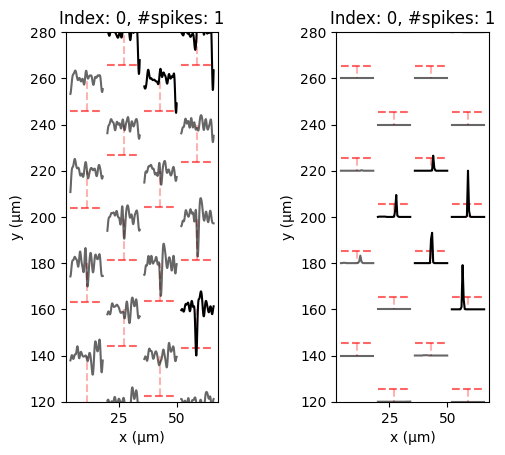

In [67]:
unit = Unit(0, [time], root_elec, RECORDING)
plot_elec_probs(unit)
plt.show()

In [56]:
np.array(get_merge_elecs(root_elec))[unit.main_elecs]

array([17, 19, 15, 18, 16])

In [217]:
from time import perf_counter

start = perf_counter()
outputs = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r")
traces = np.load(TRACES_FILT_PATH, mmap_mode="r")
end = perf_counter()
print(end - start)

0.002712238929234445


In [57]:
# Run: Form and merge sequence backbones using TRAINING_FRAMES
def job(root_elec):
    coc_clusters = form_coc_clusters(root_elec, time_frame=TRAINING_FRAMES)
    if len(coc_clusters) == 0:
        return []
    
    merged_clusters = merge_coc_clusters(coc_clusters)
    return merged_clusters

rooted_coc_clusters = []  # [[coc clusters with same root]]
with Pool(processes=20) as pool:
    tasks = range(num_elecs)
    for merged_clusters in tqdm(pool.imap(job, tasks), total=len(tasks)):
        rooted_coc_clusters.append(merged_clusters)
print(sum(len(c) for c in rooted_coc_clusters))

100%|██████████| 248/248 [00:48<00:00,  5.09it/s]


246


In [98]:
# Run: detect spikes in TRAINING_FRAMES
print("Need to use TRAINING_FRAMES, not TESTING_FRAMES on line 8")

def job(coc_clusters):
    spike_trains = []
    for cluster in coc_clusters:
        spike_trains.append(detect_spikes(cluster, time_frame=TESTING_FRAMES))
    return coc_clusters, spike_trains

rooted_prop_units = []  # [[prop units with same root]]
with Pool(processes=20) as pool:
    uid = 0
    for coc_clusters, spike_trains in tqdm(pool.imap(job, rooted_coc_clusters), total=len(rooted_coc_clusters)):
        prop_units = []
        for cluster, spike_train in zip(coc_clusters, spike_trains):
            # Convert CocClusters to Units (since Units are easier to work with)
            if len(spike_train) > 0:
                unit = Unit(uid, spike_train, cluster.root_elec, None)         
                unit.root_elec = cluster.root_elec  # Needed for merging
                uid += 1
                prop_units.append(unit)
        if len(prop_units) > 0:
            rooted_prop_units.append(prop_units)

Need to use TRAINING_FRAMES, not TESTING_FRAMES on line 8


100%|██████████| 248/248 [00:31<00:00,  7.84it/s]


In [99]:
# Run: Intraelectrode merging
def job(units):
    if len(units) == 1:
        setup_cluster(units[0])
        return units
    merged_units = merge_coc_clusters(units)
    
    # Fix ISI violations
    for unit in merged_units:
        unit.spike_train = fix_isi_viols(unit.spike_train)
        
    return merged_units

intramerged_prop_units = []
with Pool(processes=20) as pool:
    idx = 0
    for merged_units in tqdm(pool.imap(job, rooted_prop_units), total=len(rooted_prop_units)):
        for unit in merged_units:
            unit.idx = idx
            intramerged_prop_units.append(unit)
            idx += 1
print(len(intramerged_prop_units))

100%|██████████| 182/182 [00:11<00:00, 16.25it/s]


213


In [116]:
# Run: Interelectrode merging
prop_intermerged_units = merge_coc_clusters(
    deepcopy(intramerged_prop_units), 
    max_root_elec_dist=50,
    auto_setup_coc_clusters=False, verbose=True
)

for idx, unit in enumerate(prop_intermerged_units):
    unit.idx = idx
    unit.spike_train = fix_isi_viols(unit.spike_train)

NameError: name 'intramerged_prop_units' is not defined

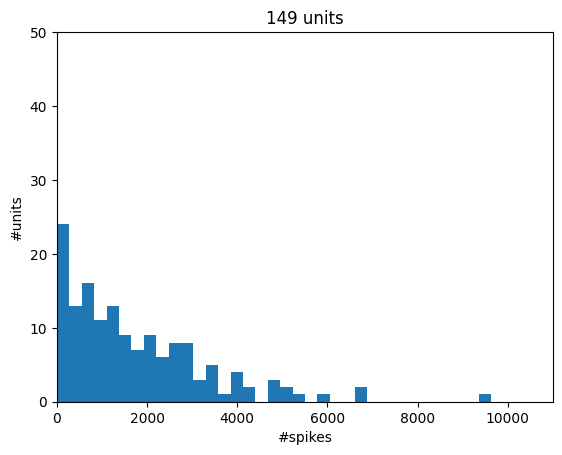

In [104]:
# (optional) Run: plot nums spikes distribution
prop_signal = SpikeSorter(RECORDING, "RT-Sort", units=prop_intermerged_units)
prop_signal.plot_nums_spikes()

In [94]:
# Run: Detect spikes in TESTING_FRAMES
def job(unit):
    spike_train = detect_spikes(unit, time_frame=TESTING_FRAMES)
    unit.spike_train = spike_train
    return unit

prop_units = []
with Pool(processes=20) as pool:
    idx = 0 
    for unit in tqdm(pool.imap(job, prop_intermerged_units), total=len(prop_intermerged_units)):
        if len(unit.spike_train) > 0:
            unit.spike_train = fix_isi_viols(unit.spike_train)
            unit.recording = RECORDING
            unit.idx = idx
            idx += 1
            prop_units.append(unit)

100%|██████████| 147/147 [00:12<00:00, 11.46it/s]


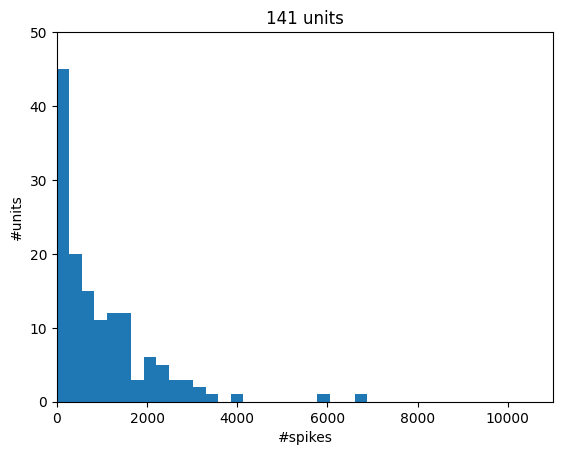

In [95]:
# Run: store units in prop_signal
prop_signal = SpikeSorter(RECORDING, "RT-Sort", units=prop_units)
prop_signal.plot_nums_spikes()

In [ ]:
# SAVE_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/231011/spike_times.npy")
# np.save(SAVE_PATH, prop_signal.get_spike_times())

In [193]:
# (optional) Run: Save prop_signal as .pickle

# recording cannot be pickled
# prop_signal.recording = None
# for unit in prop_signal:
#     unit.recording = None

# with open(f"/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/231025/prop_signal.pickle", "wb") as f:
#     pickle.dump(prop_signal, f, pickle.HIGHEST_PROTOCOL)
    
# # Set recording back
# prop_signal.recording = RECORDING
# for unit in prop_signal:
#     unit.recording = RECORDING

### Look at some merges

In [ ]:
merge = Merge(prop_pre_intermerged_units[15], prop_pre_intermerged_units[16], get_merge_elecs(prop_pre_intermerged_units[15].root_elec))
print(merge.score_latencies())
print(merge.score_rel_amps())

In [ ]:
# Look at some merges
ind = [15, 16]
##
amp_kwargs = None
for idx in ind:
    unit = prop_pre_intermerged_units[idx]
    unit.recording = RECORDING
    
    print(len(unit.spike_train))
    if amp_kwargs is None:
        amp_kwargs, prob_kwargs = plot_elec_probs(unit)
    else:
        plot_elec_probs(unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()

### Testing

100%|██████████| 3/3 [00:03<00:00,  1.19s/it]


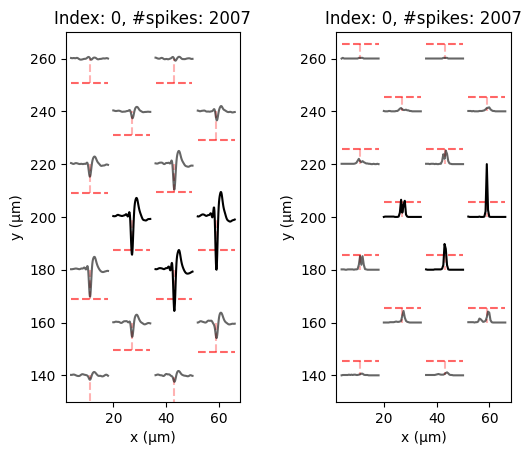

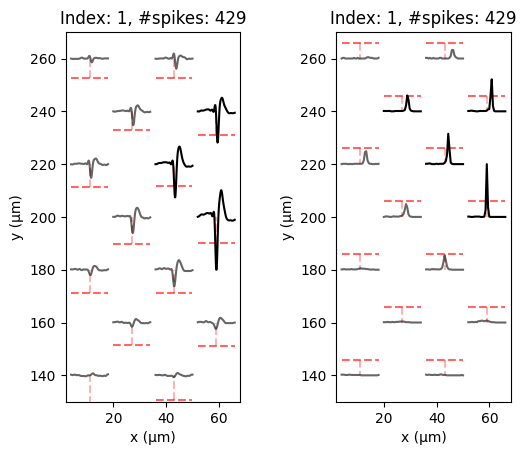

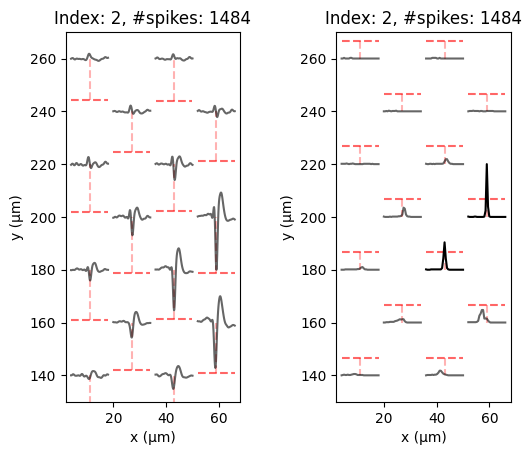

In [412]:
# Plot clusters
# elec_clusters = all_units # all_coc_clusters[:1]
# for cluster in elec_clusters:
#     cluster.root_elec = root_elec
elec_clusters = merges # all_units

# setup_coc_clusters(elec_clusters)

# for cluster in elec_clusters:
#     all_elec_probs = extract_detection_probs(cluster)
#     elec_probs = np.mean(all_elec_probs, axis=0)
    
#     cluster.latencies = np.argmax(elec_probs, axis=1) - elec_probs.shape[1]//2
#     cluster.all_elec_probs = all_elec_probs
#     cluster.elec_probs = elec_probs
#     cluster.elecs = np.flatnonzero(np.max(elec_probs, axis=1)>=prob_thresh)

units = []
def get_unit_templates(cluster_idx):
    cluster = elec_clusters[cluster_idx]
    unit = Unit(idx=cluster_idx, spike_train=cluster.spike_train, channel_idx=cluster.root_elecs[0], recording=RECORDING)
    return cluster_idx, unit.get_templates(ms_before=2, ms_after=2)

with Pool(processes=20) as pool:
    tasks = range(len(elec_clusters))
    for cluster_idx, templates in tqdm(pool.imap(get_unit_templates, tasks), total=len(tasks)):
        cluster = elec_clusters[cluster_idx]
        unit = Unit(idx=cluster_idx, spike_train=cluster.spike_train, channel_idx=cluster.root_elecs[0], recording=RECORDING)
        unit.templates = templates
        units.append(unit)
# Plot
# kwargs = None
# for i, unit in enumerate(units):
#     print(len(unit.spike_train))
#     if kwargs is None:
#         kwargs = unit.plot(chans_rms=CHANS_RMS)
#     else:
#         kwargs = unit.plot(**kwargs) 
#     plt.show()

# Plot with detection probabilities

amp_kwargs = None
for i, unit in enumerate(units):
    amp_kwargs = None
    elec_probs = np.mean(extract_detection_probs(elec_clusters[i]), axis=0)  # elec_clusters[i].elec_probs # 
    
    # print(f"comp elec: {19}, loc={elec_locs[19]}")
    # print(f"comp elec: {elec_clusters[i].elec}, loc={elec_locs[elec_clusters[i].elec]}")
    if amp_kwargs is None:
        amp_kwargs, prob_kwargs = plot_elec_probs(unit, elec_probs)
    else:
        plot_elec_probs(unit, elec_probs, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()
    
    # Plot latency histogram
    # plt.hist([c[0]*30 for c in elec_clusters[i].cocs], bins=91)
    # plt.show()

In [ ]:
unit = Unit(0, list(set(merges[0].spike_train).difference(merges[1].spike_train)), root_elec, RECORDING)
plot_elec_probs(unit)
plt.show()

unit = Unit(1, list(set(merges[1].spike_train).difference(merges[0].spike_train)), root_elec, RECORDING)
plot_elec_probs(unit)
plt.show()

len(set(merges[10].spike_train).intersection(merges[11].spike_train))

#### Improve merging by looking at roots on each electrode

In [ ]:
# Need to have task be a single unit since elecs have different number of roots (task cannot be all roots on an elec)
def get_unit(task):
    elec, idx, root = task
    
    unit = Unit(idx=idx, spike_train=root.spike_train, channel_idx=root.elecs[0], recording=RECORDING)    
    unit.set_templates()
    unit.recording = None  # h5py objects cannot be pickled
    return elec, unit

elecs_units = [[] for _ in range(len(all_roots_with_footprints))]
with Pool(processes=20) as pool:
    tasks = []
    for e, roots in enumerate(all_roots_with_footprints):
        for i, root in enumerate(roots):
            tasks.append((e, i, root))
            
    for elec, unit in tqdm(pool.imap(get_unit, tasks), total=len(tasks)):
        unit.recording = RECORDING
        elecs_units[elec].append(unit)        

100%|██████████| 299/299 [01:40<00:00,  2.98it/s]


In [ ]:
for i, unit in enumerate(units[:5]):
    print(len(unit))
    # display(elec_clusters[i].df)
    unit.plot(chans_rms=CHANS_RMS)
    # if kwargs is None:
    #     kwargs = unit.plot(chans_rms=CHANS_RMS)
    # else:
    #     unit.plot(**kwargs)
    
    plt.show()

### Testing

In [205]:
prop_a = merges[1]
prop_b = merges[6]

In [206]:
merge = Merge(prop_a, prop_b)
print(merge.score_latencies())
print(merge.score_rel_amps())

1.13653564453125
0.3781696


In [161]:
merge.get_elec_weights(merge.closest_elecs)

array([0.2732  , 0.0662  , 0.1917  , 0.1048  , 0.011604, 0.1385  ,
       0.00967 , 0.02492 , 0.02966 , 0.01274 , 0.00891 , 0.0425  ,
       0.008896, 0.01714 , 0.01958 , 0.01242 , 0.00934 , 0.01782 ],
      dtype=float16)

In [158]:
prop_a.elecs

[17, 19, 15, 18, 21, 13, 22, 14, 16, 20, 23, 11, 24, 12, 9, 25, 26, 10]

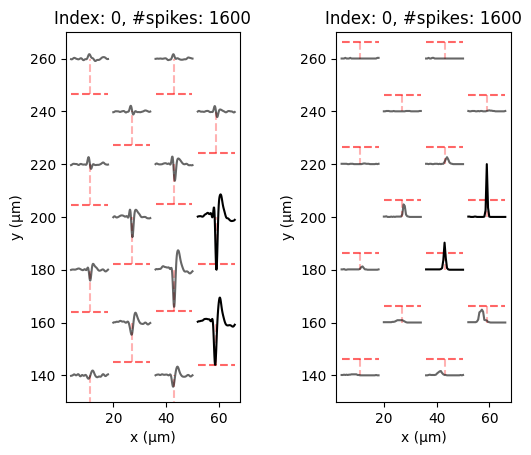

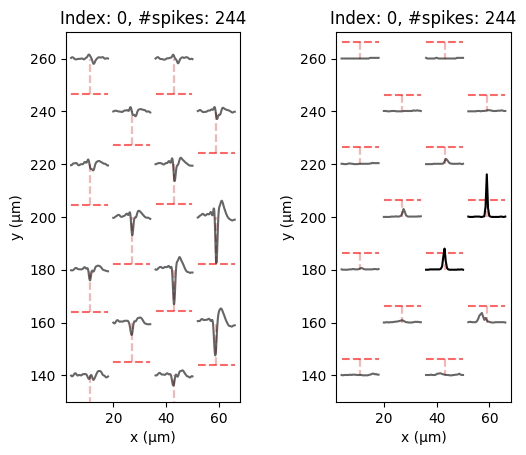

In [195]:
amp_kwargs = None
for unit in [prop_a, prop_b]:
    if amp_kwargs is None:
        amp_kwargs, prob_kwargs = plot_elec_probs(unit)
    else:
        plot_elec_probs(unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()

In [86]:
print(len(set(prop_a.spike_train).intersection(prop_b.spike_train)))
print(len(prop_a.spike_train), len(prop_b.spike_train))

184
1651 1666


In [374]:
units = [prop_signal[0], prop_signal[1]]
setup_coc_clusters(units)
merge = Merge(units[0], units[1], get_merge_elecs(0))
print(merge.score_latencies())
print(merge.score_rel_amps())

0.12902069091796875
0.048466966


1761


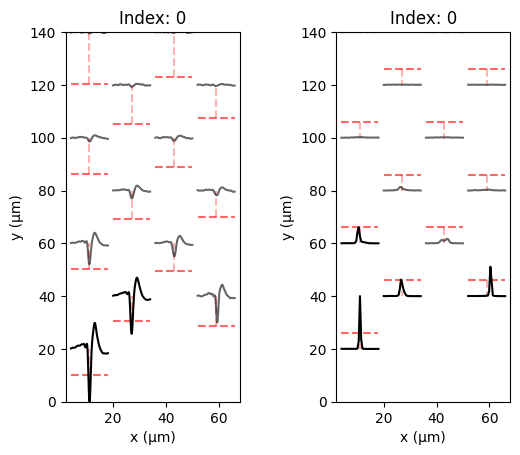

2973


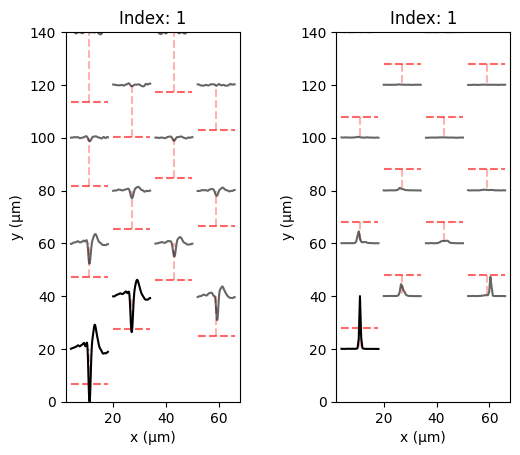

In [373]:
for unit in units:
    print(len(unit.spike_train))
    plot_elec_probs(unit)
    plt.show()

2339


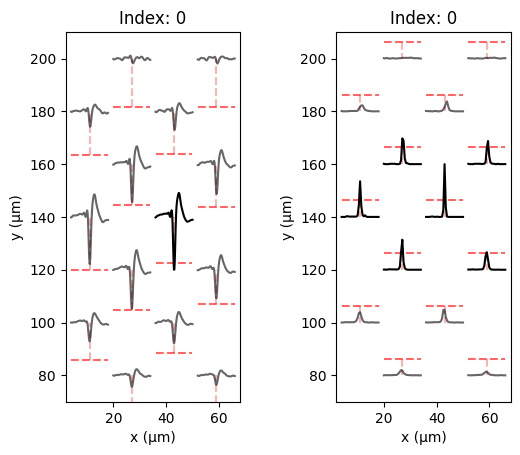

In [269]:
# Compare detected spikes to backbone
print(len(spike_train))
unit = Unit(0, spike_train, coc_cluster.root_elec, RECORDING)
plot_elec_probs(unit, np.mean(extract_detection_probs(unit), axis=0))
plt.show()

print(f"Backbone")
print(len(coc_cluster.spike_train))
unit = Unit(0, coc_cluster.spike_train, coc_cluster.root_elec, RECORDING)
plot_elec_probs(unit, np.mean(extract_detection_probs(unit), axis=0))
plt.show()

In [ ]:
# SAVE_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/231011/spike_times.npy")
# np.save(SAVE_PATH, prop_signal.get_spike_times())

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
